In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("cleaned_dataset.csv")
df.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,...,payment_type,payment_installments,payment_value,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,seller_zip_code_prefix,seller_city,seller_state
0,00010242fe8c5a6d1ba2dd792cb16214,1.0,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,9/19/2017 9:45,58.90,13.29,cool_stuff,58.0,598.0,...,credit_card,2.0,72.19,871766c5855e863f6eccc05f988b23cb,28013.0,campos dos goytacazes,RJ,27277.0,volta redonda,SP
1,000229ec398224ef6ca0657da4fc703e,1.0,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,1/18/2018 14:48,49.90,17.87,moveis_decoracao,59.0,695.0,...,credit_card,5.0,67.53,3818d81c6709e39d06b2738a8d3a2474,35661.0,para de minas,MG,12327.0,borda da mata,MG
2,00024acbcdf0a6daa1e931b038114c75,1.0,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,8/15/2018 10:10,12.99,12.79,perfumaria,42.0,480.0,...,credit_card,2.0,25.78,af861d436cfc08b2c2ddefd0ba074622,12952.0,atibaia,SP,14403.0,franca,SP
3,00048cc3ae777c65dbb7d2a0634bc1ea,1.0,ef92defde845ab8450f9d70c526ef70f,6426d21aca402a131fc0a5d0960a3c90,5/23/2017 3:55,21.90,12.69,utilidades_domesticas,36.0,558.0,...,boleto,1.0,34.59,85c835d128beae5b4ce8602c491bf385,38017.0,uberaba,MG,14091.0,ribeirao preto,SP
4,00054e8431b9d7675808bcb819fb4a32,1.0,8d4f2bb7e93e6710a28f34fa83ee7d28,7040e82f899a04d1b434b795a43b4617,12/14/2017 12:10,19.90,11.85,telefonia,52.0,815.0,...,credit_card,1.0,31.75,635d9ac1680f03288e72ada3a1035803,16700.0,guararapes,SP,1026.0,sao paulo,SP


In [3]:
df.columns


Index(['order_id', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value',
       'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'product_category_name_english', 'customer_id', 'order_status',
       'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'review_id', 'review_score',
       'review_comment_title', 'review_comment_message',
       'review_creation_date', 'review_answer_timestamp', 'payment_sequential',
       'payment_type', 'payment_installments', 'payment_value',
       'customer_unique_id', 'customer_zip_code_prefix', 'customer_city',
       'customer_state', 'seller_zip_code_prefix', 'seller_city',
       'seller_state'],
      dtype='object')

In [4]:
df.shape

(39352, 40)

In [5]:
df.duplicated().value_counts()

False    39352
Name: count, dtype: int64

In [6]:
# Check for duplicates
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

# Drop duplicates if necessary
data = df.drop_duplicates()


Number of duplicate rows: 0


In [7]:
# Convert columns to datetime
date_columns = ['order_purchase_timestamp', 'order_delivered_customer_date', 'shipping_limit_date']
for col in date_columns:
    data[col] = pd.to_datetime(data[col])

# Convert numeric columns
numeric_columns = ['price', 'freight_value', 'product_weight_g', 'product_length_cm']
data[numeric_columns] = data[numeric_columns].apply(pd.to_numeric, errors='coerce')


In [8]:
# Use IQR to handle outliers
Q1 = data['price'].quantile(0.25)
Q3 = data['price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
data = data[(data['price'] >= lower_bound) & (data['price'] <= upper_bound)]


In [9]:
data['purchase_day'] = data['order_purchase_timestamp'].dt.day
data['purchase_week'] = data['order_purchase_timestamp'].dt.isocalendar().week
data['purchase_month'] = data['order_purchase_timestamp'].dt.month
data['purchase_year'] = data['order_purchase_timestamp'].dt.year


In [10]:
# Total spending per customer
customer_spending = data.groupby('customer_unique_id')['price'].sum().reset_index()
customer_spending.rename(columns={'price': 'total_spent'}, inplace=True)

# Number of orders per customer
customer_orders = data.groupby('customer_unique_id')['order_id'].nunique().reset_index()
customer_orders.rename(columns={'order_id': 'order_count'}, inplace=True)

# Merge back into the main dataset
data = data.merge(customer_spending, on='customer_unique_id', how='left')
data = data.merge(customer_orders, on='customer_unique_id', how='left')


In [11]:
# Calculate volume for products
data['product_volume_cm3'] = (
    data['product_length_cm'] * data['product_height_cm'] * data['product_width_cm']
)

# Create price per unit weight
data['price_per_gram'] = data['price'] / data['product_weight_g']


In [12]:
# Total sales by state
state_sales = data.groupby('customer_state')['price'].sum().reset_index()

# Number of customers per city
city_customers = data.groupby('customer_city')['customer_unique_id'].nunique().reset_index()

# Merge back if needed
data = data.merge(state_sales, on='customer_state', how='left', suffixes=('', '_state_sales'))


In [13]:
# Using IQR for outlier detection
Q1 = data['price'].quantile(0.25)
Q3 = data['price'].quantile(0.75)
IQR = Q3 - Q1

# Filter outliers
outliers = data[(data['price'] < (Q1 - 1.5 * IQR)) | (data['price'] > (Q3 + 1.5 * IQR))]
print(f"Number of Outliers in Price: {len(outliers)}")

Number of Outliers in Price: 78


In [14]:
# Filter the dataset to keep only non-outliers
clean_data = data[(data['price'] >= (Q1 - 1.5 * IQR)) & (data['price'] <= (Q3 + 1.5 * IQR))]

print(f"Number of Records After Removing Outliers: {len(clean_data)}")


Number of Records After Removing Outliers: 38424


In [15]:
data['late_delivery'] = pd.to_datetime(data['order_delivered_customer_date']) > pd.to_datetime(data['order_estimated_delivery_date'])
late_delivery_rate = data['late_delivery'].mean() * 100
print(f"Late Delivery Rate: {late_delivery_rate:.2f}%")

Late Delivery Rate: 4.19%


In [16]:
customer_orders = data.groupby('customer_unique_id')['order_id'].count()
repeat_customers = customer_orders[customer_orders > 1].count()
total_customers = customer_orders.count()

retention_rate = (repeat_customers / total_customers) * 100
print(f"Customer Retention Rate: {retention_rate:.2f}%")

Customer Retention Rate: 2.12%


In [17]:
data.shape

(38502, 50)

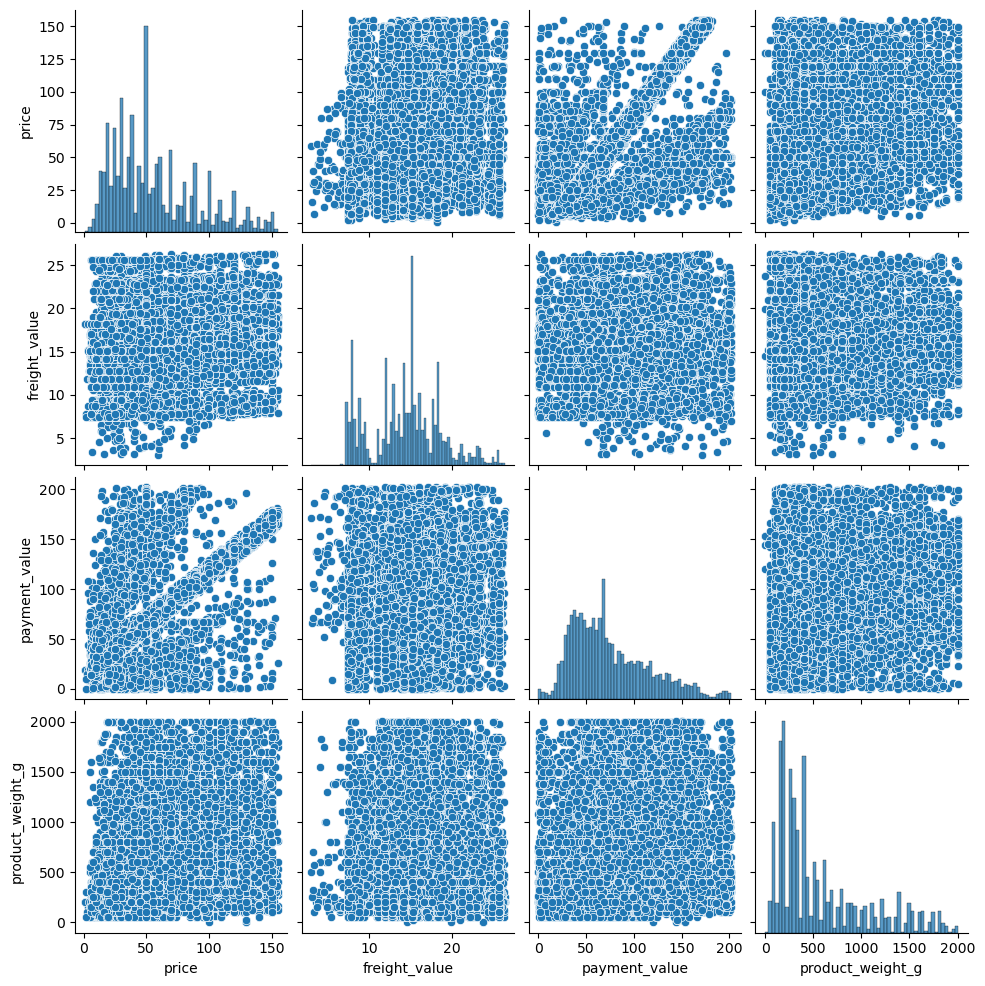

In [18]:
sns.pairplot(data[['price', 'freight_value', 'payment_value', 'product_weight_g']])
plt.show()

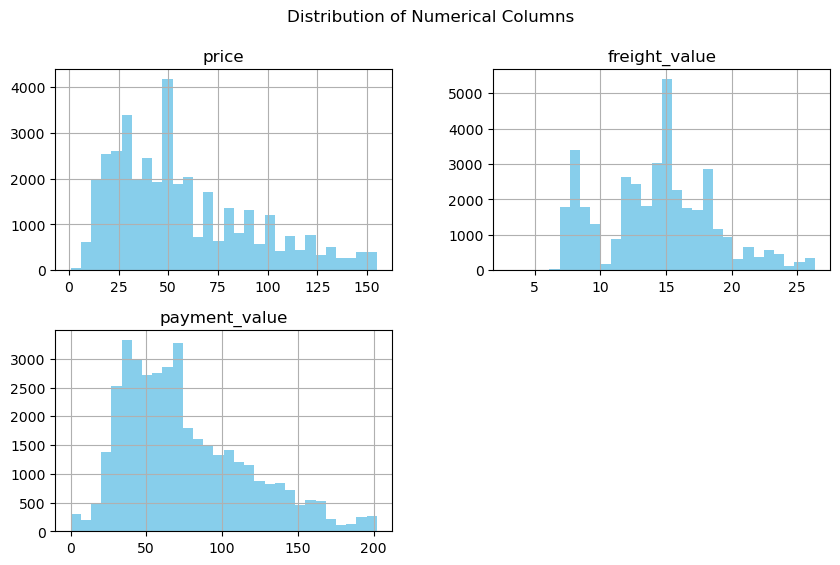

In [19]:
# Plot histograms for numerical columns
data[['price', 'freight_value', 'payment_value']].hist(bins=30, figsize=(10, 6), color='skyblue')
plt.suptitle("Distribution of Numerical Columns")
plt.show()


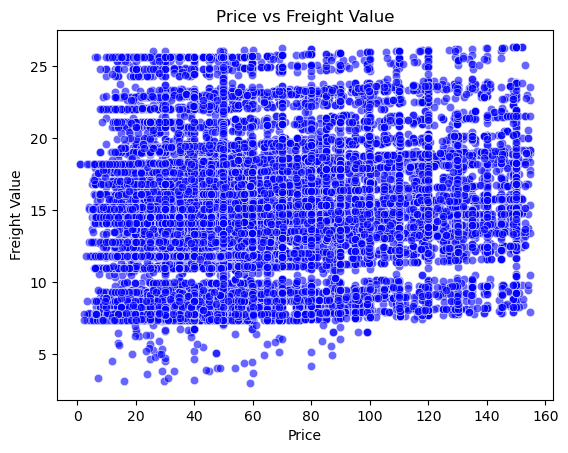

In [20]:
sns.scatterplot(x='price', y='freight_value',data=data, alpha=0.6, color='blue')
plt.title("Price vs Freight Value")
plt.xlabel("Price")
plt.ylabel("Freight Value")
plt.show()


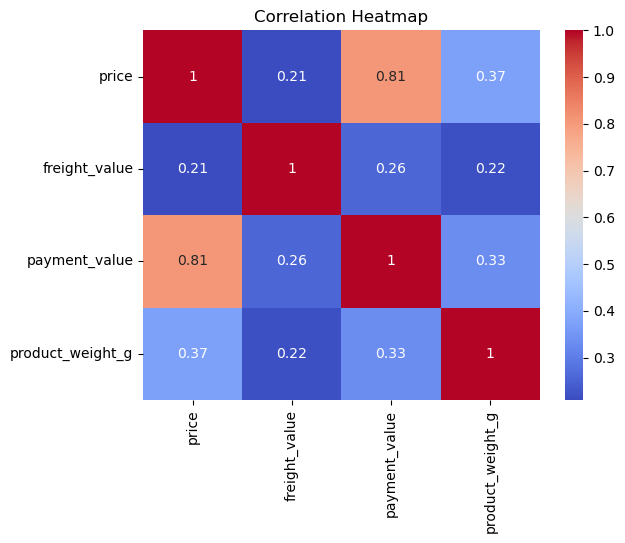

In [21]:
# Compute correlation
correlation = data[['price', 'freight_value', 'payment_value', 'product_weight_g']].corr()

# Plot heatmap
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()


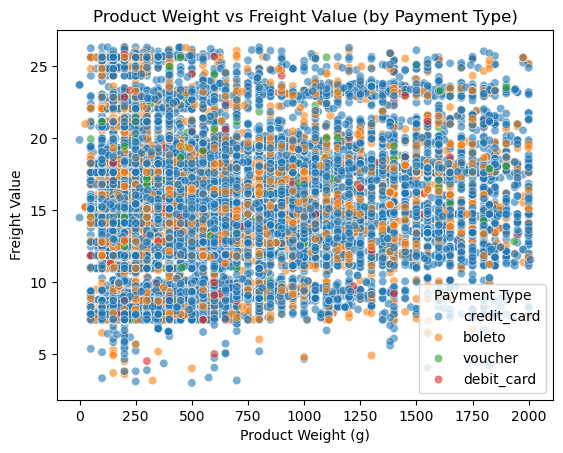

In [22]:
sns.scatterplot(x='product_weight_g', y='freight_value', hue='payment_type', data=data, alpha=0.6)
plt.title("Product Weight vs Freight Value (by Payment Type)")
plt.xlabel("Product Weight (g)")
plt.ylabel("Freight Value")
plt.legend(title="Payment Type")
plt.show()


C:\Users\ahmed\AppData\Local\Temp\ipykernel_10548\1951530948.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='payment_type', data=data, palette='viridis')


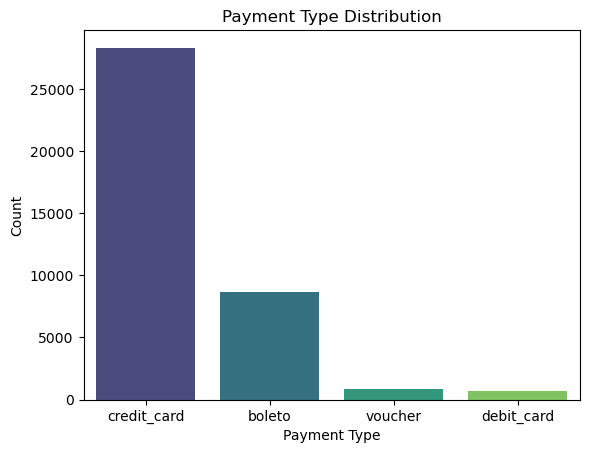

In [23]:
sns.countplot(x='payment_type', data=data, palette='viridis')
plt.title("Payment Type Distribution")
plt.xlabel("Payment Type")
plt.ylabel("Count")
plt.show()


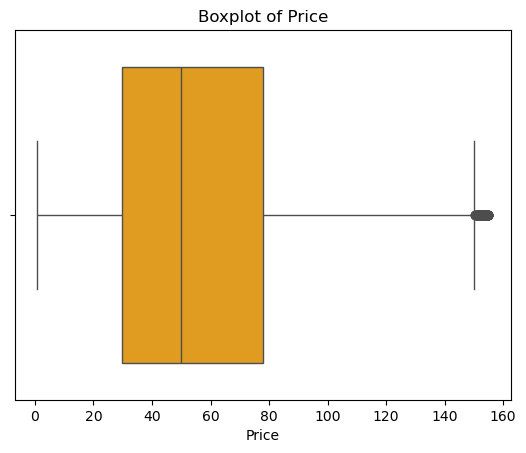

In [24]:
sns.boxplot(x=data['price'], color='orange')
plt.title("Boxplot of Price")
plt.xlabel("Price")
plt.show()

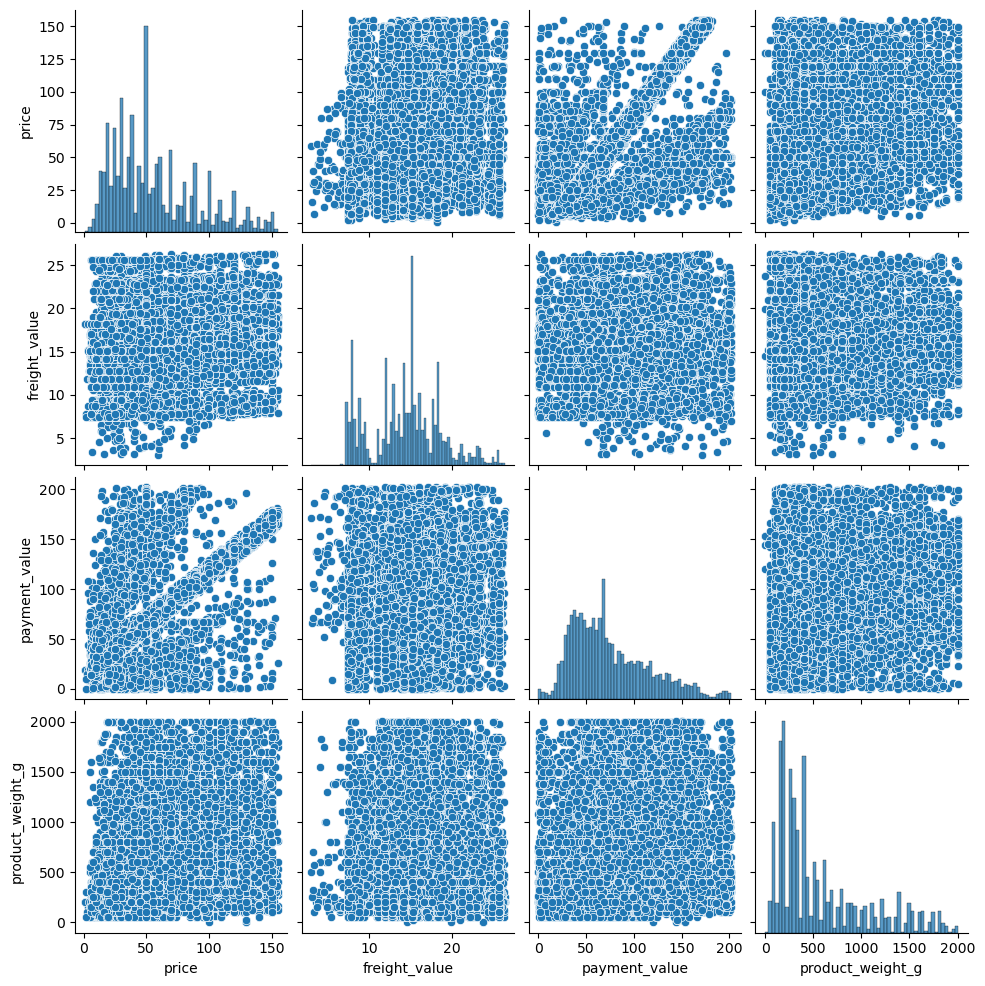

In [25]:
sns.pairplot(data[['price', 'freight_value', 'payment_value', 'product_weight_g']])
plt.show()


# Statistics

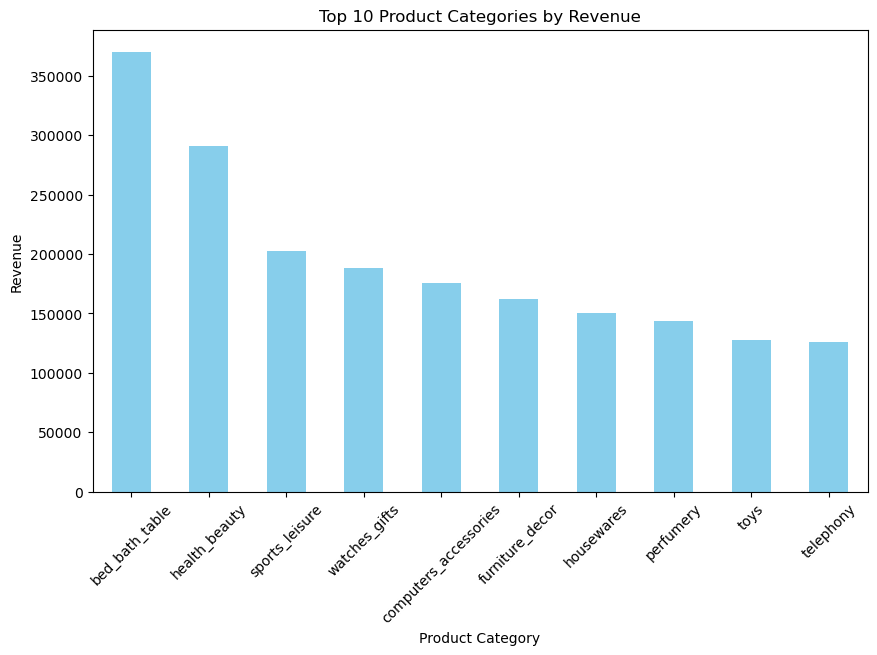

In [26]:
#sales and Revenue Analysis
category_revenue = data.groupby('product_category_name_english')['payment_value'].sum().sort_values(ascending=False)

# Plot
category_revenue.head(10).plot(kind='bar', color='skyblue', figsize=(10, 6))
plt.title("Top 10 Product Categories by Revenue")
plt.xlabel("Product Category")
plt.ylabel("Revenue")
plt.xticks(rotation=45)
plt.show()


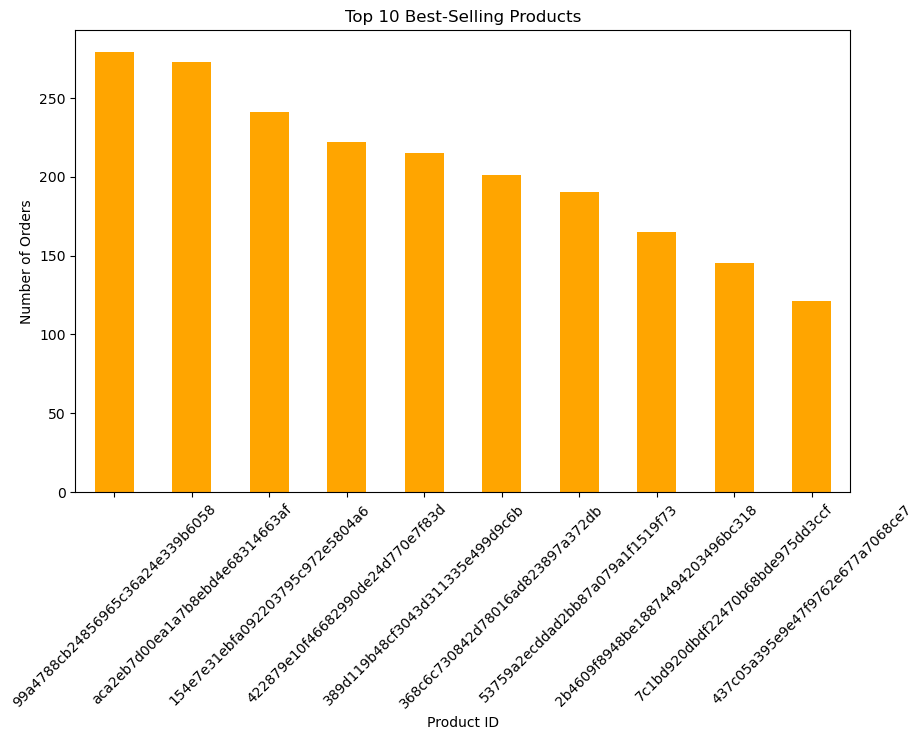

In [27]:
top_products = data.groupby('product_id')['order_item_id'].count().sort_values(ascending=False)

# Plot
top_products.head(10).plot(kind='bar', color='orange', figsize=(10, 6))
plt.title("Top 10 Best-Selling Products")
plt.xlabel("Product ID")
plt.ylabel("Number of Orders")
plt.xticks(rotation=45)
plt.show()


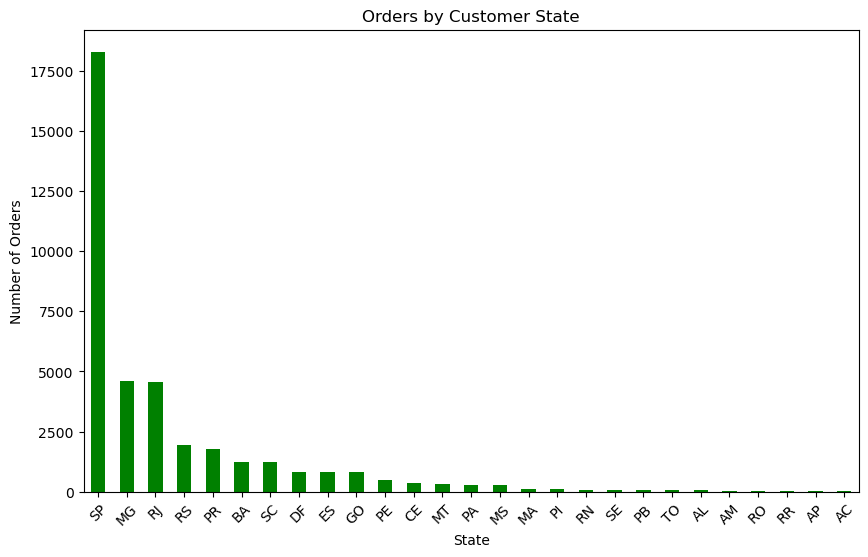

In [28]:
order_by_state = data['customer_state'].value_counts()

# Plot
order_by_state.plot(kind='bar', color='green', figsize=(10, 6))
plt.title("Orders by Customer State")
plt.xlabel("State")
plt.ylabel("Number of Orders")
plt.xticks(rotation=45)
plt.show()


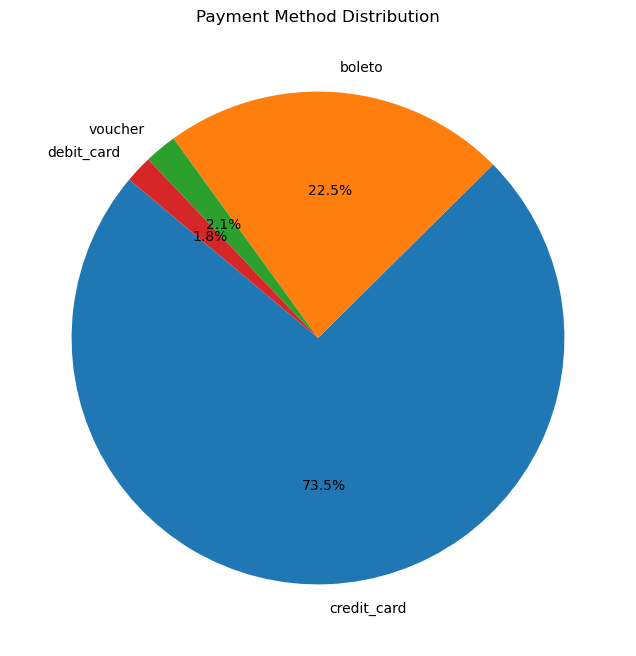

In [29]:
payment_types = data['payment_type'].value_counts()

# Plot
payment_types.plot(kind='pie', autopct='%1.1f%%', figsize=(8, 8), startangle=140)
plt.title("Payment Method Distribution")
plt.ylabel("")
plt.show()


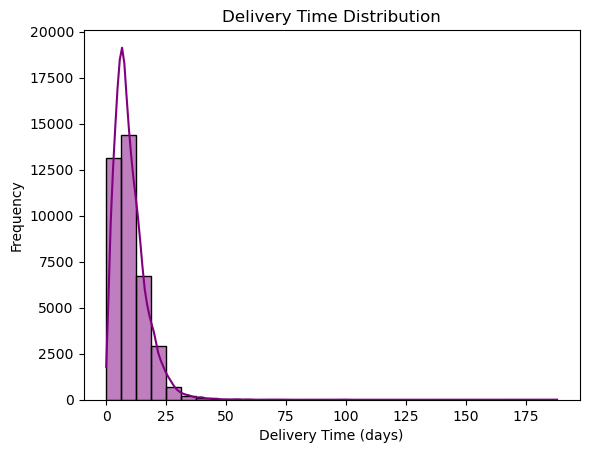

In [30]:
# Calculate delivery times
data['delivery_time'] = (pd.to_datetime(data['order_delivered_customer_date']) - pd.to_datetime(data['order_purchase_timestamp'])).dt.days

# Plot
sns.histplot(data['delivery_time'].dropna(), kde=True, bins=30, color='purple')
plt.title("Delivery Time Distribution")
plt.xlabel("Delivery Time (days)")
plt.ylabel("Frequency")
plt.show()


In [31]:
# Check if delivered late
data['late_delivery'] = pd.to_datetime(data['order_delivered_customer_date']) > pd.to_datetime(data['order_estimated_delivery_date'])
late_percentage = data['late_delivery'].mean() * 100
print(f"Percentage of Late Deliveries: {late_percentage:.2f}%")


Percentage of Late Deliveries: 4.19%


In [32]:
average_review_score = data['review_score'].mean()
print(f"Average Review Score: {average_review_score:.2f}")


Average Review Score: 4.58


C:\Users\ahmed\AppData\Local\Temp\ipykernel_10548\2188747231.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='review_score', data=data, palette='muted')


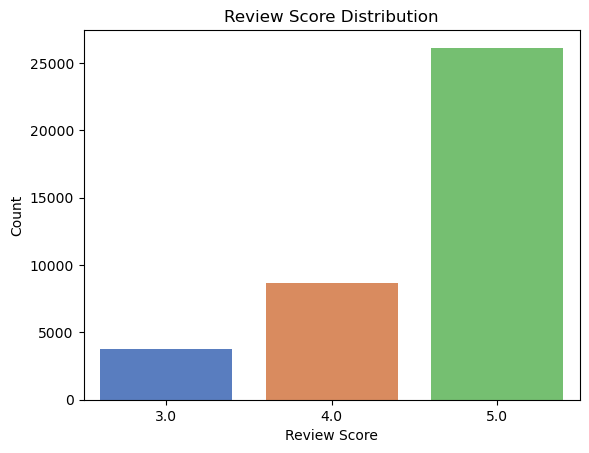

In [33]:
sns.countplot(x='review_score', data=data, palette='muted')
plt.title("Review Score Distribution")
plt.xlabel("Review Score")
plt.ylabel("Count")
plt.show()


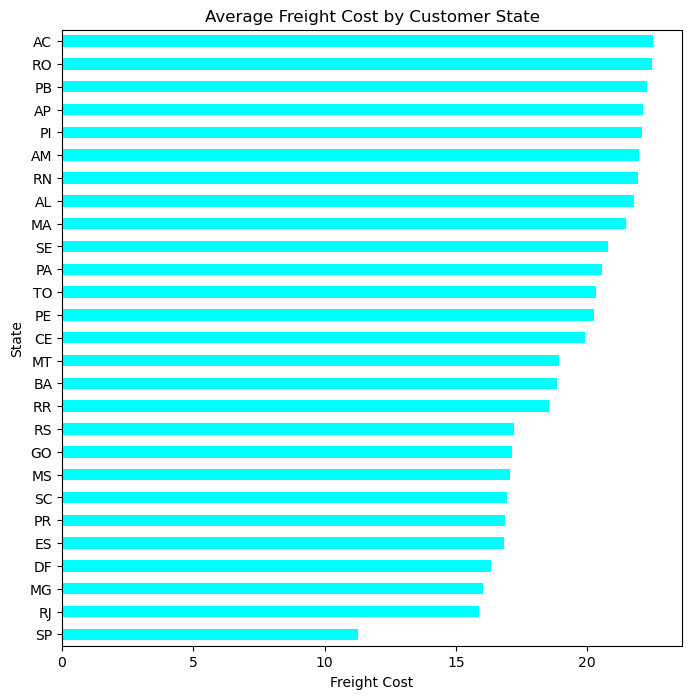

In [34]:
state_freight = data.groupby('customer_state')['freight_value'].mean().sort_values()

# Plot
state_freight.plot(kind='barh', color='cyan', figsize=(8, 8))
plt.title("Average Freight Cost by Customer State")
plt.xlabel("Freight Cost")
plt.ylabel("State")
plt.show()


C:\Users\ahmed\AppData\Local\Temp\ipykernel_10548\3401245290.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=bar_labels, y=bar_sizes, palette='pastel')


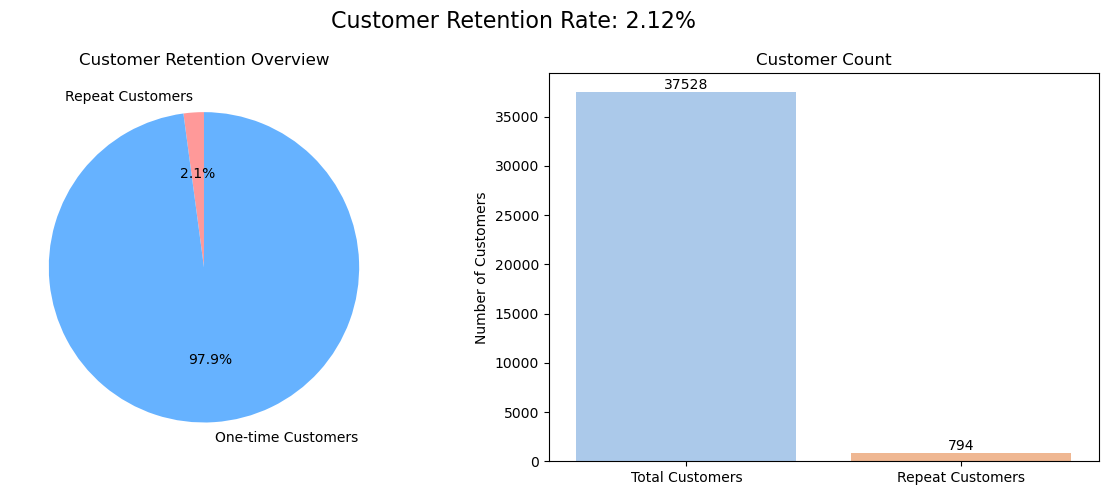

Total Unique Customers: 37528
Repeat Customers: 794
Customer Retention Rate: 2.12%

Customer Order Frequency Distribution:
order_id
1     36734
2       665
3        93
4        27
5         8
11        1
Name: count, dtype: int64


In [35]:
# Calculate customer retention metrics
customer_orders = data.groupby('customer_unique_id')['order_id'].count()
repeat_customers = customer_orders[customer_orders > 1].count()
total_customers = customer_orders.count()

retention_rate = (repeat_customers / total_customers) * 100

# Create visualization
plt.figure(figsize=(12, 5))

# Pie Chart
plt.subplot(1, 2, 1)
pie_labels = ['Repeat Customers', 'One-time Customers']
pie_sizes = [repeat_customers, total_customers - repeat_customers]
colors = ['#FF9999', '#66B2FF']
plt.pie(pie_sizes, labels=pie_labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Customer Retention Overview')

# Bar Chart
plt.subplot(1, 2, 2)
bar_labels = ['Total Customers', 'Repeat Customers']
bar_sizes = [total_customers, repeat_customers]
sns.barplot(x=bar_labels, y=bar_sizes, palette='pastel')
plt.title('Customer Count')
plt.ylabel('Number of Customers')

# Add value labels on top of bars
for i, v in enumerate(bar_sizes):
    plt.text(i, v, str(v), ha='center', va='bottom')

# Overall figure title
plt.suptitle(f'Customer Retention Rate: {retention_rate:.2f}%', fontsize=16)

plt.tight_layout()
plt.show()

# Print detailed metrics
print(f"Total Unique Customers: {total_customers}")
print(f"Repeat Customers: {repeat_customers}")
print(f"Customer Retention Rate: {retention_rate:.2f}%")

# Additional insights
print("\nCustomer Order Frequency Distribution:")
order_frequency = customer_orders.value_counts().sort_index()
print(order_frequency)

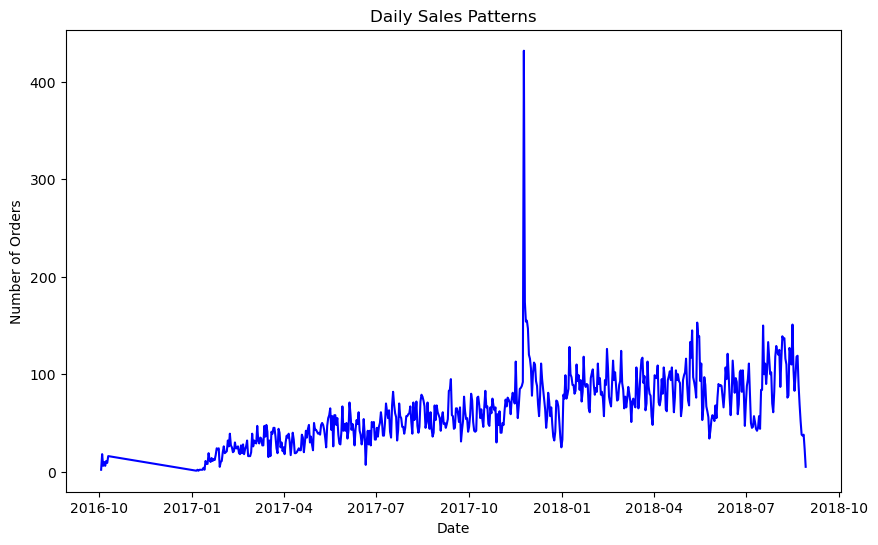

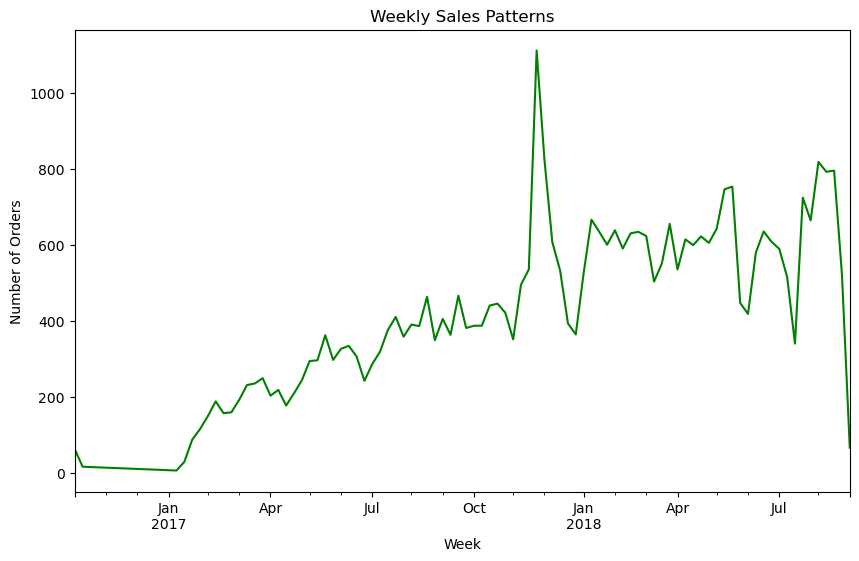

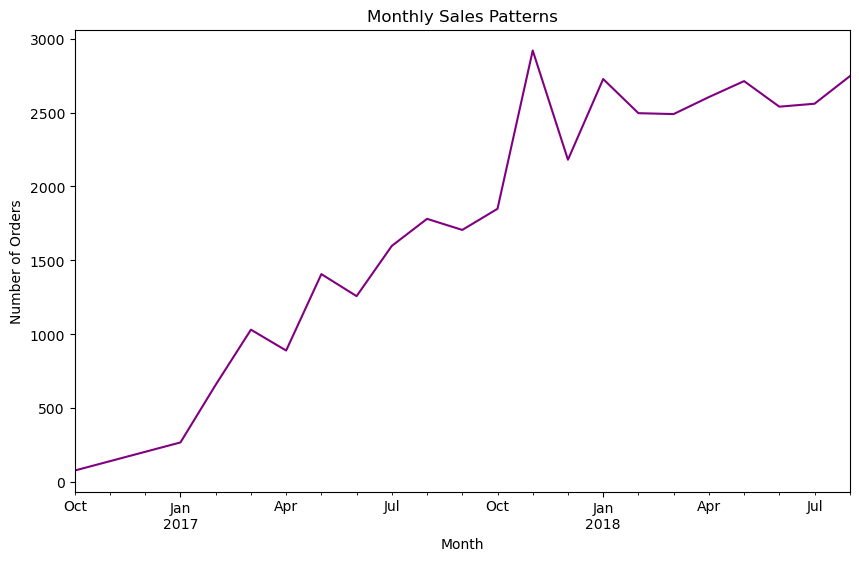

In [36]:
# Convert timestamps to datetime
data['order_purchase_date'] = pd.to_datetime(data['order_purchase_timestamp'])

# Daily sales
daily_sales = data.groupby(data['order_purchase_date'].dt.date)['order_id'].count()
daily_sales.plot(kind='line', figsize=(10, 6), color='blue', title="Daily Sales Patterns")
plt.xlabel("Date")
plt.ylabel("Number of Orders")
plt.show()

# Weekly sales
data['order_week'] = data['order_purchase_date'].dt.to_period('W')
weekly_sales = data.groupby('order_week')['order_id'].count()
weekly_sales.plot(kind='line', figsize=(10, 6), color='green', title="Weekly Sales Patterns")
plt.xlabel("Week")
plt.ylabel("Number of Orders")
plt.show()

# Monthly sales
data['order_month'] = data['order_purchase_date'].dt.to_period('M')
monthly_sales = data.groupby('order_month')['order_id'].count()
monthly_sales.plot(kind='line', figsize=(10, 6), color='purple', title="Monthly Sales Patterns")
plt.xlabel("Month")
plt.ylabel("Number of Orders")
plt.show()


C:\Users\ahmed\AppData\Local\Temp\ipykernel_10548\2499977946.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=monthly_trends.index, y=monthly_trends.values, palette='viridis')


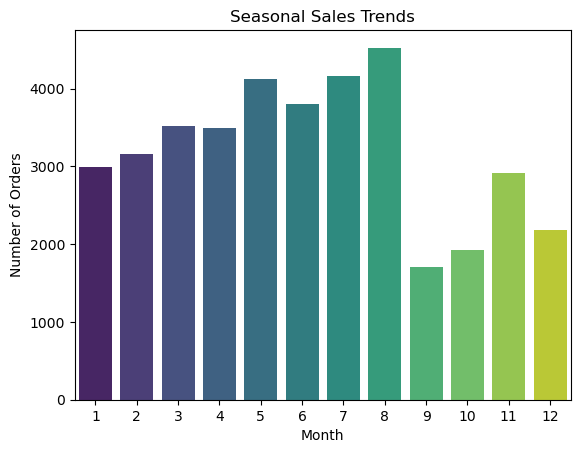

In [37]:
# Extract month and plot sales trends by month
data['month'] = data['order_purchase_date'].dt.month
monthly_trends = data.groupby('month')['order_id'].count()
sns.barplot(x=monthly_trends.index, y=monthly_trends.values, palette='viridis')
plt.title("Seasonal Sales Trends")
plt.xlabel("Month")
plt.ylabel("Number of Orders")
plt.show()


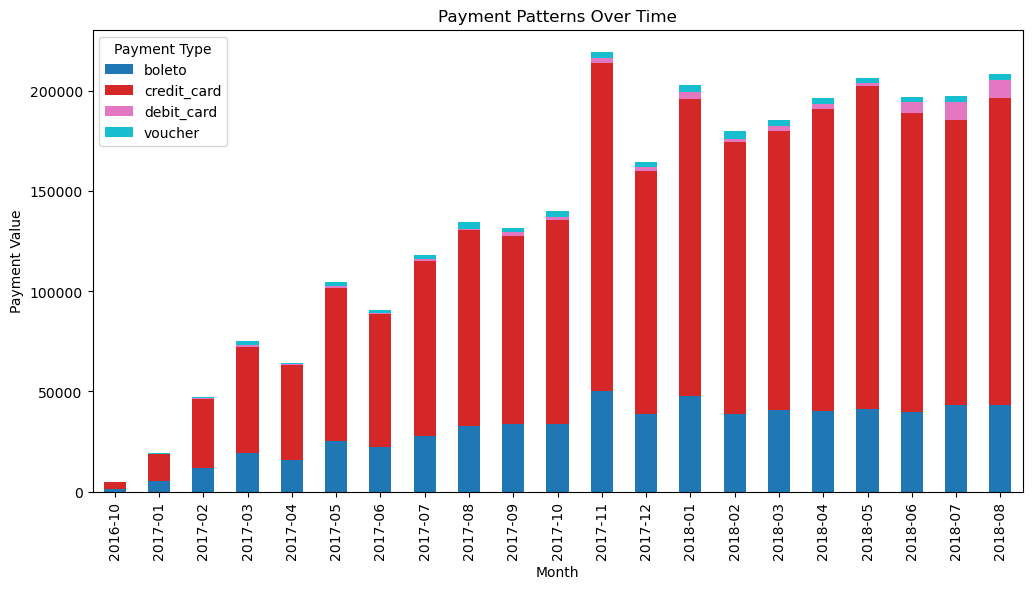

In [38]:
# Payment patterns by month
payment_trends = data.groupby(['order_month', 'payment_type'])['payment_value'].sum().unstack()
payment_trends.plot(kind='bar', stacked=True, figsize=(12, 6), cmap='tab10')
plt.title("Payment Patterns Over Time")
plt.xlabel("Month")
plt.ylabel("Payment Value")
plt.legend(title="Payment Type")
plt.show()


C:\Users\ahmed\AppData\Local\Temp\ipykernel_10548\2353779327.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=state_counts.index, x=state_counts.values, palette='coolwarm')


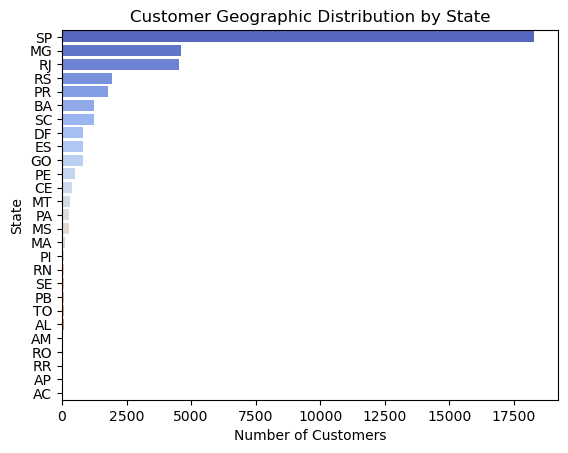

In [39]:
# Customer location analysis
state_counts = data['customer_state'].value_counts()
sns.barplot(y=state_counts.index, x=state_counts.values, palette='coolwarm')
plt.title("Customer Geographic Distribution by State")
plt.xlabel("Number of Customers")
plt.ylabel("State")
plt.show()


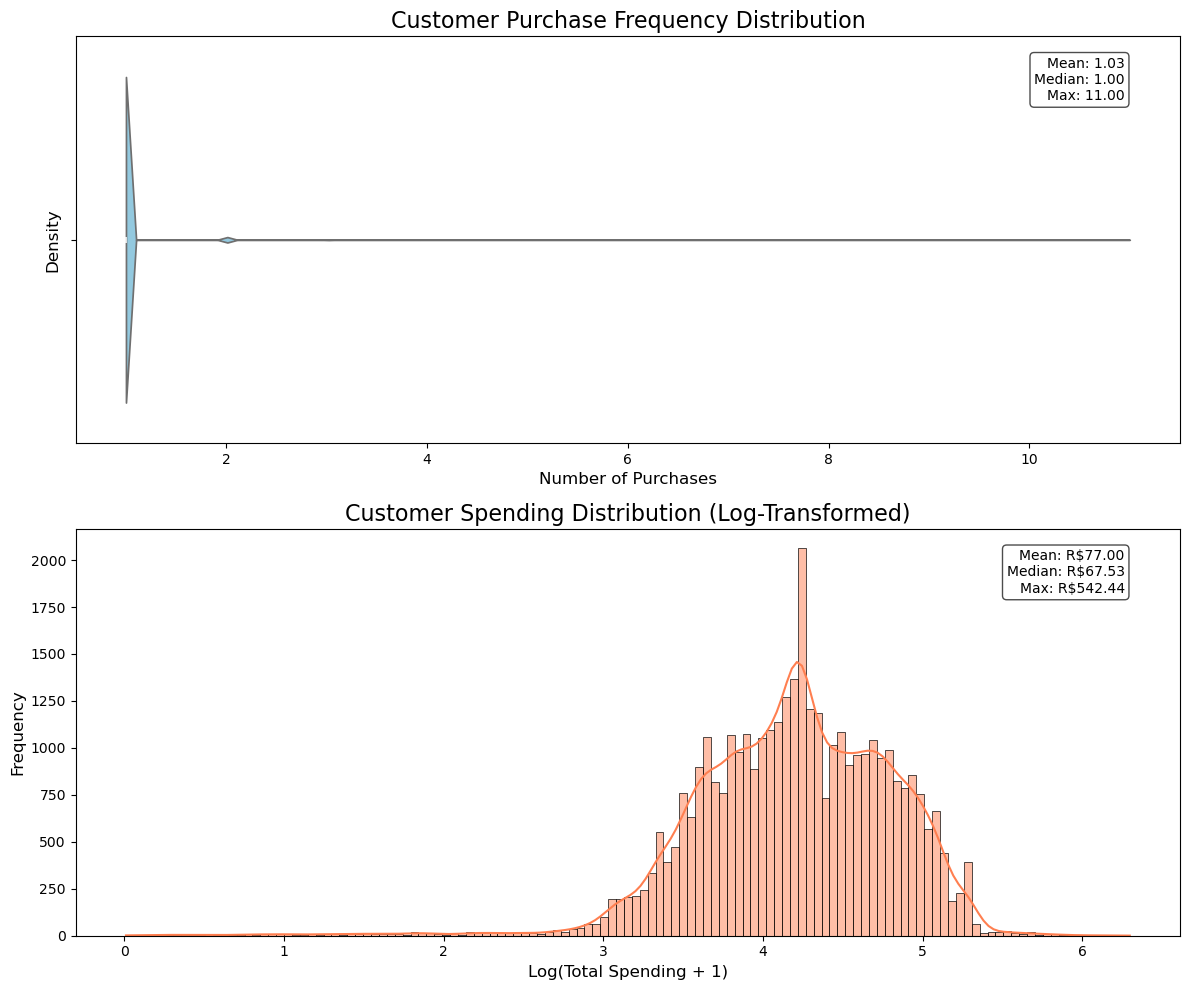

Purchase Frequency Statistics:
count    37528.000000
mean         1.025954
std          0.198773
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         11.000000
Name: order_id, dtype: float64

Customer Spending Statistics:
count    37528.000000
mean        77.004497
std         43.585361
min          0.010000
25%         44.110000
50%         67.530000
75%        102.640000
max        542.440000
Name: payment_value, dtype: float64

Customer Purchase Frequency Distribution:
order_id
One-time          97.884246
2 purchases        1.772010
3-5 purchases      0.341079
10+ purchases      0.002665
6-10 purchases     0.000000
Name: proportion, dtype: float64


In [40]:
import numpy as np

# Calculate purchase frequency and total spending
purchase_frequency = data.groupby('customer_unique_id')['order_id'].count()
customer_spending = data.groupby('customer_unique_id')['payment_value'].sum()

# Set up the figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Purchase Frequency Plot with improved visualization
ax1.clear()
sns.violinplot(x=purchase_frequency, ax=ax1, color='skyblue', cut=0)
ax1.set_title('Customer Purchase Frequency Distribution', fontsize=16)
ax1.set_xlabel('Number of Purchases', fontsize=12)
ax1.set_ylabel('Density', fontsize=12)

# Add key statistics to the plot
freq_stats = {
    'Mean': purchase_frequency.mean(),
    'Median': purchase_frequency.median(),
    'Max': purchase_frequency.max()
}
stats_text = '\n'.join([f'{k}: {v:.2f}' for k, v in freq_stats.items()])
ax1.text(0.95, 0.95, stats_text, transform=ax1.transAxes, 
         verticalalignment='top', horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

# Customer Spending Plot with log scale and detailed visualization
ax2.clear()
# Use log-transformed data for better visualization
log_spending = np.log1p(customer_spending)
sns.histplot(log_spending, kde=True, color='coral', ax=ax2)
ax2.set_title('Customer Spending Distribution (Log-Transformed)', fontsize=16)
ax2.set_xlabel('Log(Total Spending + 1)', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)

# Add key statistics to the spending plot
spend_stats = {
    'Mean': customer_spending.mean(),
    'Median': customer_spending.median(),
    'Max': customer_spending.max()
}
stats_text = '\n'.join([f'{k}: R${v:.2f}' for k, v in spend_stats.items()])
ax2.text(0.95, 0.95, stats_text, transform=ax2.transAxes, 
         verticalalignment='top', horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

plt.tight_layout()
plt.show()

# Print out some additional insights
print("Purchase Frequency Statistics:")
print(purchase_frequency.describe())
print("\nCustomer Spending Statistics:")
print(customer_spending.describe())

# Calculate and print percentage of customers in different purchase frequency brackets
freq_brackets = pd.cut(purchase_frequency, 
                       bins=[0, 1, 2, 5, 10, np.inf], 
                       labels=['One-time', '2 purchases', '3-5 purchases', '6-10 purchases', '10+ purchases'])
freq_distribution = freq_brackets.value_counts(normalize=True) * 100
print("\nCustomer Purchase Frequency Distribution:")
print(freq_distribution)

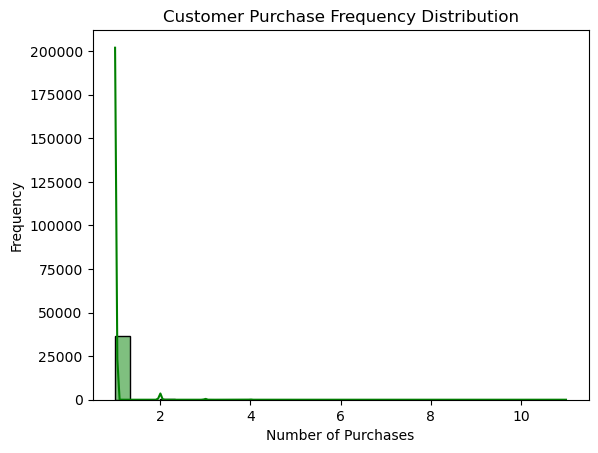

In [41]:
# Count purchases per customer
purchase_frequency = data.groupby('customer_unique_id')['order_id'].count()
sns.histplot(purchase_frequency, bins=30, kde=True, color='green')
plt.title("Customer Purchase Frequency Distribution")
plt.xlabel("Number of Purchases")
plt.ylabel("Frequency")
plt.show()


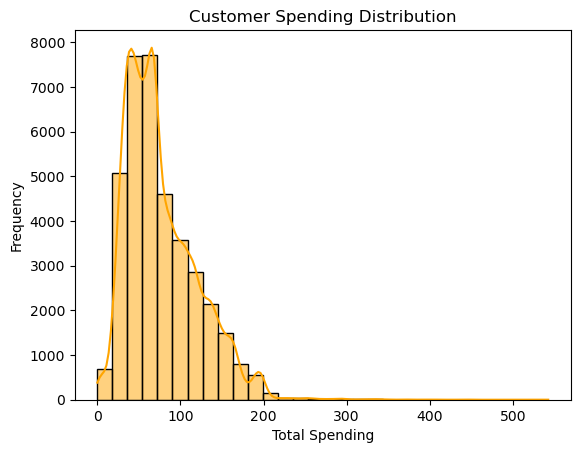

In [42]:
# Total spending per customer
customer_spending = data.groupby('customer_unique_id')['payment_value'].sum()
sns.histplot(customer_spending, bins=30, kde=True, color='orange')
plt.title("Customer Spending Distribution")
plt.xlabel("Total Spending")
plt.ylabel("Frequency")
plt.show()


C:\Users\ahmed\AppData\Local\Temp\ipykernel_10548\3173377167.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=review_impact.index, y=review_impact.values, palette='Blues')


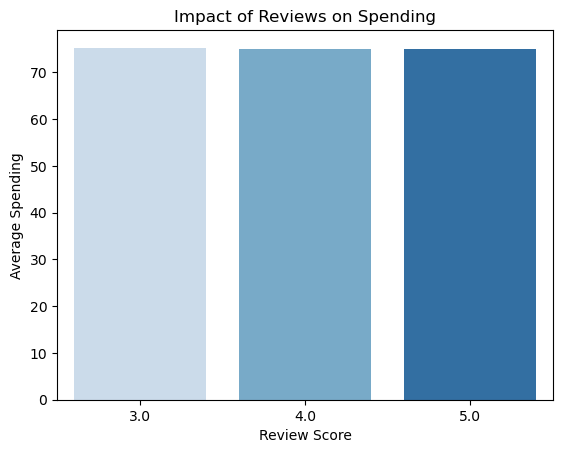

In [43]:
# Group by review score and average future spending
review_impact = data.groupby('review_score')['payment_value'].mean()
sns.barplot(x=review_impact.index, y=review_impact.values, palette='Blues')
plt.title("Impact of Reviews on Spending")
plt.xlabel("Review Score")
plt.ylabel("Average Spending")
plt.show()


C:\Users\ahmed\AppData\Local\Temp\ipykernel_10548\1615961566.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_categories.index, x=top_categories.values, palette='cool')


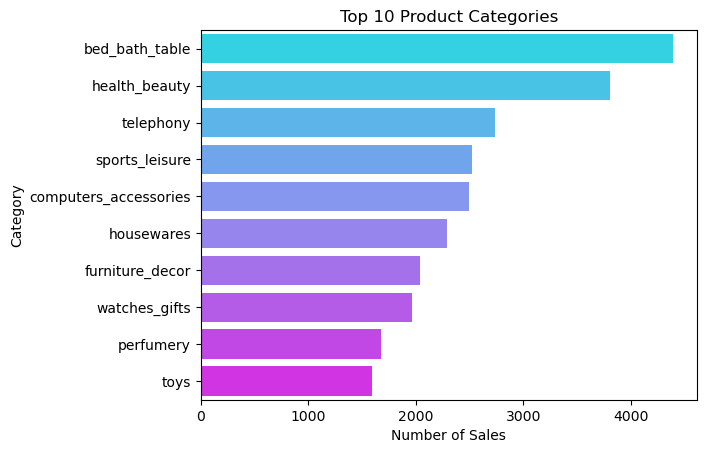

Top-Selling Products:
 product_id
99a4788cb24856965c36a24e339b6058    279
aca2eb7d00ea1a7b8ebd4e68314663af    273
154e7e31ebfa092203795c972e5804a6    241
422879e10f46682990de24d770e7f83d    222
389d119b48cf3043d311335e499d9c6b    215
368c6c730842d78016ad823897a372db    201
53759a2ecddad2bb87a079a1f1519f73    190
2b4609f8948be18874494203496bc318    165
7c1bd920dbdf22470b68bde975dd3ccf    145
437c05a395e9e47f9762e677a7068ce7    121
Name: count, dtype: int64


In [44]:
# Top-selling categories
top_categories = data['product_category_name_english'].value_counts().head(10)
sns.barplot(y=top_categories.index, x=top_categories.values, palette='cool')
plt.title("Top 10 Product Categories")
plt.xlabel("Number of Sales")
plt.ylabel("Category")
plt.show()

# Top-selling products
top_products = data['product_id'].value_counts().head(10)
print("Top-Selling Products:\n", top_products)


C:\Users\ahmed\AppData\Local\Temp\ipykernel_10548\894278640.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_price.values, y=category_price.index, palette='inferno')


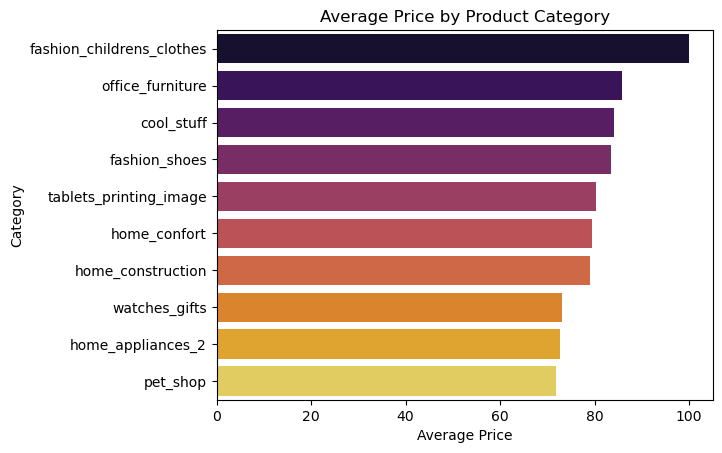

In [45]:
# Average price per category
category_price = data.groupby('product_category_name_english')['price'].mean().sort_values(ascending=False).head(10)
sns.barplot(x=category_price.values, y=category_price.index, palette='inferno')
plt.title("Average Price by Product Category")
plt.xlabel("Average Price")
plt.ylabel("Category")
plt.show()
